# N-band Imaging With SimMETIS

The purpose of this notebook is to simulate a simple N band imaging observation with METIS as well as to provide functions to simulate chopping (nodding is not implemented yet). Please also see the corresponding LM-band notebook for some features that can be applied to N-band imaging.

We start by importing packages that will be useful. 

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
%matplotlib inline

Finally, we import simmetis and check the versions of simmetis and required packages. 

In [2]:
import simmetis as sim

In [3]:
sim.bug_report()

Python:
 3.8.4rc1 (default, Jul  1 2020, 15:31:45) 
[GCC 9.3.0]

simmetis :  0.3dev
astropy :  3.2.3
synphot :  0.3
numpy :  1.18.4
scipy :  1.4.1
poppy :  0.9.0
wget :  3.2

Operating system:  Linux
         Release:  5.6.0-2-amd64
         Version:  #1 SMP Debian 5.6.14-1 (2020-05-23)
         Machine:  x86_64


### Chopped observation of a point source

Load the base configuration for N-band imaging. Explicitely set the filter used to "N2". 

In [4]:
cmd = sim.UserCommands("metis_image_N.config")
metis_filter_id = "N2"
cmd["INST_FILTER_TC"] = "TC_filter_" + metis_filter_id + ".dat"

Set up the instrument by instantiating the optical train and the detector (focal-plane array).

In [5]:
opt = sim.OpticalTrain(cmd)

In [6]:
fpa = sim.Detector(cmd, small_fov=False)

As the source to be observed, we define a point source with a flat spectrum and 9 mag in the selected filter. To simulate chopped observations, we defined two Source objects with the target position at y=0 and and y=1, respectively (units are arcsec).

In [7]:
## generate a source with 9 mag
lam, spec = sim.source.flat_spectrum(9, cmd["INST_FILTER_TC"])
src_chopA = sim.Source(lam=lam, spectra=np.array([spec]), 
                       ref=[0], x=[0], y=[0])
src_chopB = sim.Source(lam=lam, spectra=np.array([spec]), 
                       ref=[0], x=[0], y=[1])

A simulation is performed in two steps. In the first step, the optical train is applied and a "clean" image is created. This is the ideal, noiseless image that is projected onto the focal-plane array. This image is stored as the `array` attribute of `fpa`. The second step reads out the detector and adds photon and detector noise to the image.

We store the noiseless image explicitely, scaled to the chosen exposure time.

In [8]:
# Apply optical train (i.e. transmission, etc.)
src_chopA.apply_optical_train(opt, fpa)

dit = 1    # second
ndit = 1
exptime = dit * ndit

# Store noise-free image before Poisson noise is applied
noiseless_countrate = fpa.chips[0].array.T
clean_image = noiseless_countrate * exptime

# Read out the detector
hdu_A = fpa.read_out(OBS_DIT=dit, OBS_NDIT=ndit)             # image including Poisson noise

Generating image for chip 1
Reading out chip 1 using superfast
DIT = 1    NDIT = 1


In [9]:
# Repeat for chop position B
src_chopB.apply_optical_train(opt,fpa)            
hdu_B = fpa.read_out(OBS_DIT=dit, OBS_NDIT=ndit)

Generating image for chip 1
Reading out chip 1 using superfast
DIT = 1    NDIT = 1


Visualise the chopped frames, the chop difference frame and the noiseless image.

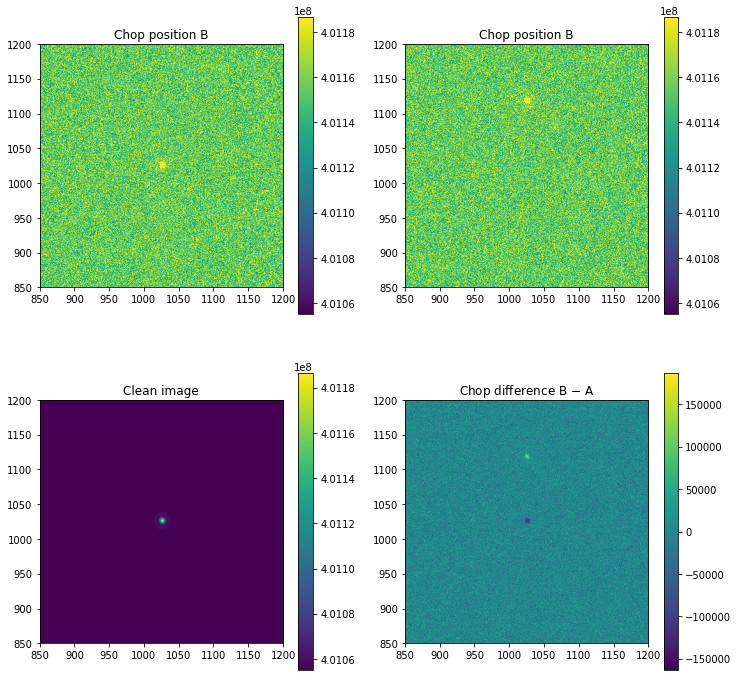

In [10]:
## chop A frame
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

xmin, ymin, xmax, ymax = 850, 850, 1200, 1200
vmin = clean_image.min()
vmax = clean_image.max()
imgA = hdu_A[0].data[xmin:xmax, ymin:ymax]
imgB = hdu_B[0].data[xmin:xmax, ymin:ymax]
imgAn = clean_image[xmin:xmax, ymin:ymax]
imgBA = imgB - imgA

plot_A = axes[0, 0].imshow(imgA, origin="lower", vmin=vmin, vmax=vmax, extent=(xmin, xmax, ymin, ymax))
axes[0, 0].set_title("Chop position B")
fig.colorbar(plot_A, ax=axes[0, 0])

## chop A frame without noise
plot_An = axes[1, 0].imshow(imgAn, origin='lower', vmin=vmin, vmax=vmax, extent=(xmin, xmax, ymin, ymax))
axes[1, 0].set_title("Clean image")
fig.colorbar(plot_An, ax=axes[1, 0])

## chop B frame
plot_B = axes[0, 1].imshow(imgB, origin='lower', vmin=vmin, vmax=vmax, extent=(xmin, xmax, ymin, ymax))
axes[0, 1].set_title("Chop position B")
fig.colorbar(plot_B, ax=axes[0, 1])

## chop difference A-B frame
## this is the "final science-grade data product" in this simulation. Nodding is not required
##    since it is only needed to correct for chop-residuals which we do not simulate.
plot_AB = axes[1, 1].imshow(imgBA, origin="lower", extent=(xmin, xmax, ymin, ymax))
axes[1, 1].set_title(r"Chop difference B $-$ A")
fig.colorbar(plot_AB, ax=axes[1, 1])

Save the chop difference image to disk. Unfortunately, there is currently no automatic way in SimMETIS to write this file with a proper FITS header. This will change in future versions with ScopeSim.

In [11]:
try:
    fits.writeto("testAB.fits", data=imgB - imgA)
except OSError:
    print("The file already exists. Remove the file or change the file name in the line above.")

The file already exists. Remove the file or change the file name in the line above.


### ELFN

This section demonstrates how to simulate ELFN noise for the Aquarius detector. Since the METIS baseline has changed to using the GeoSnap detector, this section is not relevant any more. It is left in here because it might be instructive nevertheless.

In [12]:
from  scipy.interpolate import interp1d
def ELFN_penalty(photonflux):
    x=[0, 2e8, 8e8,10e8,25e8] # [ph/s/pix]
    y=[1,1.37,3.38,3.64,4.65] # ELFN noise penalty factor
    penalty_interp=interp1d(x,y)
    penalty=penalty_interp(photonflux)[()]
    return(penalty)

In [13]:
## in order to simulate ELFN noise with SimMETIS, we currently take the following approach:
##
## (1) we first generate an image of pure noise by removing a noise-less image 
##     from the final image)
noise = hdu_A[0].data - clean_image
##
## (2) we compute the photonflux from the detected background count rate (assume a detector
##     QE of 60% for simplicity; it is close to the actual AQUARIUS level)
photonflux = noiseless_countrate / 0.6
##
## (2) then we multiply the ELFN noise penalty to this noise image and add the noise
##     back to the noiseless image; the result is the final ("chop-nod subtracted") frame 
##     including ELFN.
elfn_image = clean_image + ELFN_penalty(photonflux) * noise
##
## we can compare the noise from before with the noise after and see that the noise has
##    increased by about a factor of 2.5, as expected given the background level ~ 5e8 ph/s/px.
print(np.std(hdu_A[0].data[200:400,200:400]))
print(np.std(elfn_image[200:400,200:400]))

19933.171326015636
58588.06927155886
